In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from os.path import join as pjoin
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style("whitegrid", {'axes.grid': False})
import h5py
import tensorflow as tf

from keras import backend as K
#gpu_opts = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4))
#K.set_session(tf.Session(config=gpu_opts))
#K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Looks for files in current directory
folder_path = './data/'

# (User) Loads all the data, this file needs to be in the path defined by folder_path
data = h5py.File(pjoin(folder_path, 'cleaned_data.mat'))
f = h5py.File(pjoin(folder_path, 'cleaned_data.mat'), 'r')
for name, data in f.items():
    print(name)  # Name

LPF_cutOff
bandFilt
comb
filt_AI_mat
freqUnit
phase_deg
tol


In [3]:
%%time
loop_data = f['filt_AI_mat'][()]

CPU times: user 49.3 s, sys: 3.55 s, total: 52.8 s
Wall time: 52.5 s


In [4]:
loop_data.shape  # (n_T, n_x, n_y)

(16384, 256, 256)

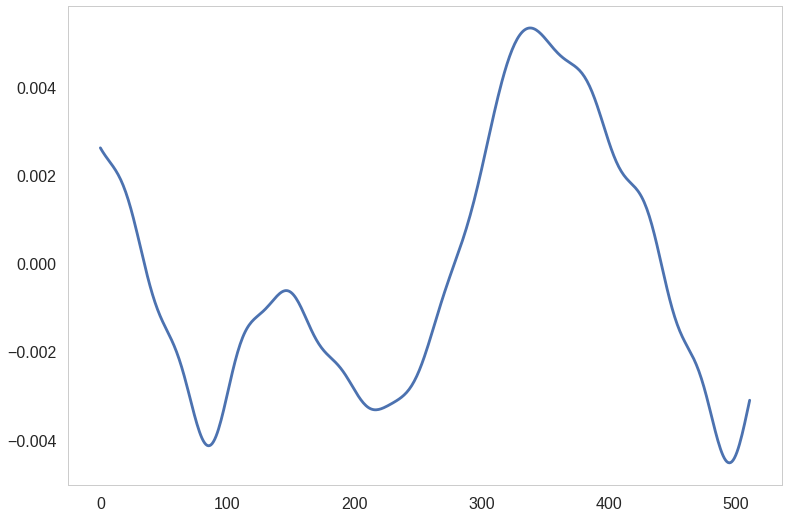

In [5]:
plt.plot(loop_data[0:512, 1, 1])

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, RepeatVector, Reshape, LSTM


def dense_auto(size, n_step, drop_frac=0., activation='relu', **kwargs):
    model = Sequential()
    model.add(Dense(size, input_shape=(n_step,), activation=activation))
    if drop_frac > 0.:
        model.add(Dropout(drop_frac))
    model.add(Dense(n_step, activation='linear'))
    
    return model


def rnn_auto(size, n_step, drop_frac=0., **kwargs):
    model = Sequential()
    model.add(Reshape((n_step, 1), input_shape=(n_step,)))
    model.add(LSTM(size, return_sequences=False))
    if drop_frac > 0.:
        model.add(Dropout(drop_frac))

    model.add(RepeatVector(n_step))
    model.add(LSTM(size, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(n_step, activation='linear'))
    
    return model

In [29]:
from keras.optimizers import Adam, SGD
from keras_tqdm import TQDMNotebookCallback

X = np.rollaxis(loop_data.reshape(loop_data.shape[0], -1), 1)
X = X.reshape((-1, 256))
X /= np.std(X)
train = np.arange(1024)
#valid = np.arange(len(train), len(train) + int(1e3))

size = 16
drop_frac = 0.0
lr = 3e-3
batch_size = len(train)
model_fun = dense_auto

model = model_fun(size, n_step=X.shape[-1], drop_frac=drop_frac, activation='linear')
model.compile(Adam(lr), loss='mse')

history = model.fit(X[train], X[train], epochs=5000, batch_size=batch_size,
                    callbacks=[],#[TQDMNotebookCallback(leave_outer=True, leave_inner=False)],
                    verbose=False)

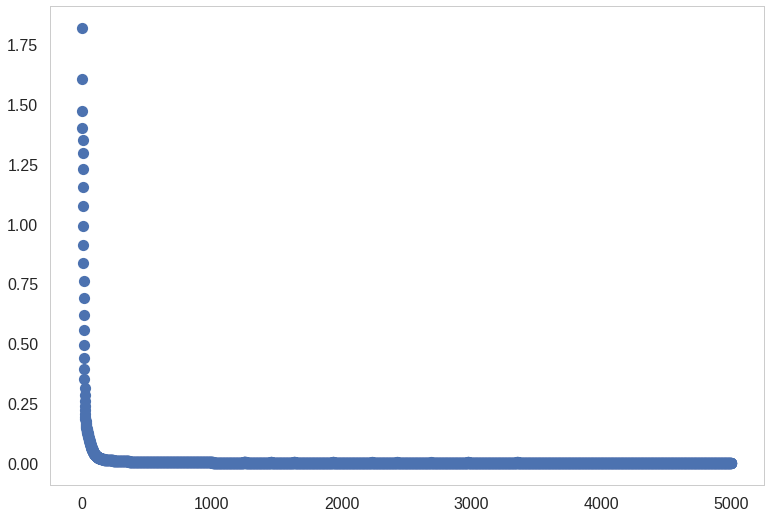

In [30]:
plt.plot(history.history['loss'], 'o')

0.00019873865768868114

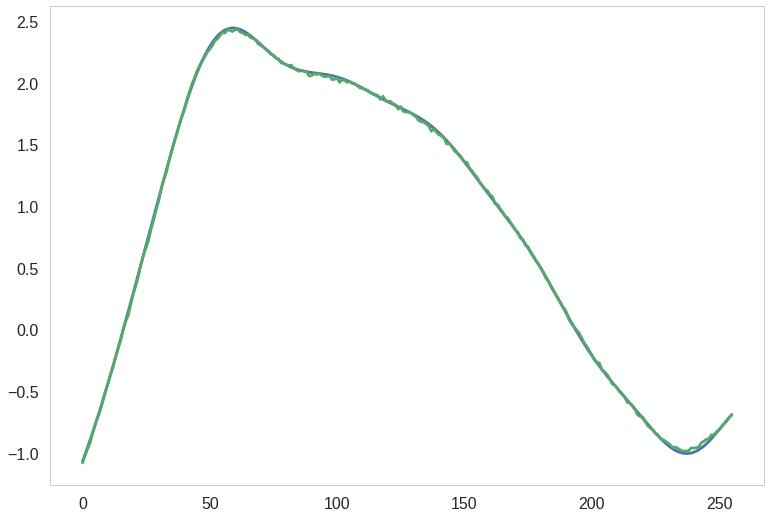

In [31]:
i = 0

plt.plot(X[i])
plt.plot(model.predict(X[[i]])[0])
np.mean((X[i] - model.predict(X[[i]])[0]) ** 2)

In [32]:
%%time
from sklearn.decomposition import PCA

pca_model = PCA(16)
pca_model.fit(X[train])

CPU times: user 339 ms, sys: 62.9 ms, total: 402 ms
Wall time: 16.5 ms


9.2538338125128645e-06

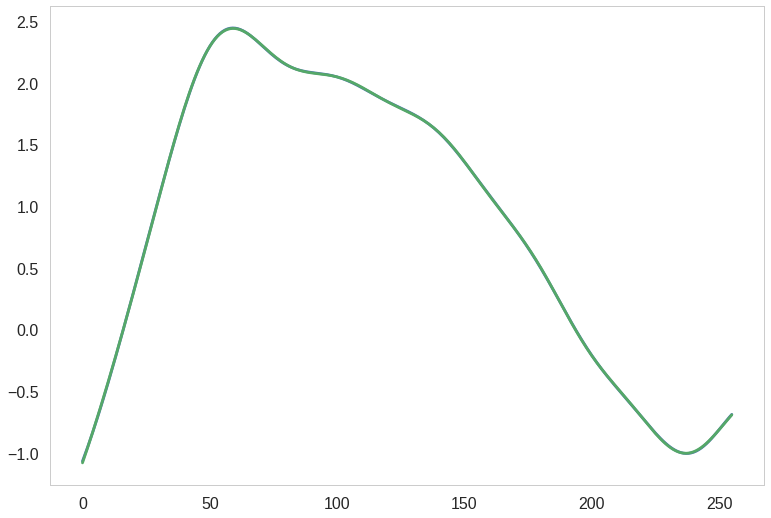

In [33]:
i = 0

plt.plot(X[i])
plt.plot(pca_model.inverse_transform(pca_model.transform(X[[i]])[0]))
np.mean((X[i] - pca_model.inverse_transform(pca_model.transform(X[[i]])[0])) ** 2)